In [13]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import time
from matplotlib import animation
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [14]:
def schaffer_function(mat_x_y, bound_values):
    min_mat = bound_values.T[0, :]
    max_mat = bound_values.T[1,:]
    mat_x_y_denorm = mat_x_y * (max_mat - min_mat) + min_mat
    x = mat_x_y_denorm[:, 0]
    y = mat_x_y_denorm[:, 1]
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

100%|██████████| 50/50 [00:00<00:00, 447.21it/s]

[[ 0.55694962  0.55249349]
 [ 0.54975983  0.44067177]
 [ 0.56380782  0.45012592]
 [ 0.43100256  0.45383205]
 [ 0.45241161  0.73105758]
 [ 0.65176113  0.67698176]
 [ 0.72468243  0.56105341]
 [ 0.72428354  0.58178011]
 [ 0.27149636  0.43013146]
 [ 0.39436565  0.28540628]
 [ 0.58763327  0.72446566]
 [ 0.66923213  0.32809681]
 [ 0.58469887  0.51546801]
 [ 0.67377723  0.65008233]
 [ 0.64811129  0.30925988]
 [ 0.52680964  0.74041097]
 [ 0.33396562  0.32388448]
 [ 0.73978358  0.53703128]
 [ 0.27653793  0.54688314]
 [ 0.11133532  0.57049887]
 [ 0.62421654  0.69122434]
 [ 0.43122926  0.50871937]
 [ 0.73206771  0.57389854]
 [ 0.52436425  0.72589678]
 [ 0.35488058  0.32644626]
 [ 0.68017119  0.36325443]
 [ 0.53731228  0.58201033]
 [ 0.25605112  0.98987373]
 [ 0.39658111  0.30059463]
 [ 0.86694353  0.61287657]
 [ 0.58827289  0.47996895]
 [ 0.50348188  0.27559625]
 [ 0.3245437   0.32644256]
 [ 0.30891495  0.61718209]
 [ 0.276706    0.51618542]
 [ 0.47590709  0.25337585]
 [ 0.63220406  0.85843164]
 

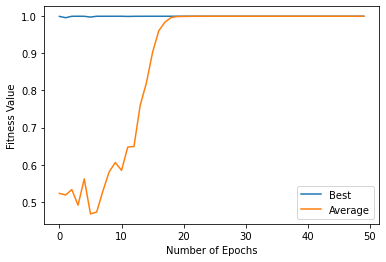

In [36]:
class CMA_ES():
    def __init__(self,
                 num_epochs:int,
                 lamb:int,
                 mi:int,
                 chrom_length:int,
                 value_ranges:list,
                 fitness_func,
                 seed=1,
                 eval_every = 10,
                 verbose=0,
                 maintain_history=False,
                 sigma=0.0444,
                ):
        
        np.random.seed(seed=seed)
        self.num_epochs = num_epochs
        self.N = chrom_length
        self.x_mean = np.array([0.5]*self.N)
        self.lamb = lamb
        self.sigma = sigma # Step size
        self.mi = mi # Number of best candidates
        self.C = np.identity(self.N)
        self.fitness_func = fitness_func
        self.value_ranges = value_ranges
        #self.sigma = np.expand_dims(np.random.rand(self.N), axis=1).T
        self.C = np.identity(self.N)
        self.cov_mat = (self.sigma ** 2) * self.C
        self.weights = np.log(self.mi+1/2)-np.log(range(1, self.mi + 1))
        self.weights = self.weights/self.weights.sum()
        self.maintain_history = maintain_history
        self.x_i_history = []


        self.best_ind_list = np.zeros(self.num_epochs)
        self.avg_ind_list = np.zeros(self.num_epochs)
        self.eval_every = eval_every
        self.verbose = verbose

        self.min_mat = self.value_ranges.T[0, :]
        self.max_mat = self.value_ranges.T[1,:]


    def step(self):
        self.x_i = np.random.multivariate_normal(self.x_mean, self.cov_mat, size=self.lamb)
        #rows_to_delete = np.any(self.x_i > 1, axis=1)
        #self.x_i = self.x_i[~rows_to_delete]
        #rows_to_delete = np.any(self.x_i < 0, axis=1)
        #self.x_i = self.x_i[~rows_to_delete]

        self.f_x_i = self.fitness_func(self.x_i, self.value_ranges)

        mask = (-self.f_x_i).argsort()
        self.f_x_i = self.f_x_i[mask]
        self.x_i = self.x_i[mask]
        self.best_indvs = self.x_i[0:self.mi]
        self.cov_mat = np.cov(self.best_indvs.T)
        self.x_mean = np.dot(self.weights, self.best_indvs)
        #print(self.cov_mat)

        # Update step size (sigma) 
        # Need to improve this part
        #p_sigma = np.zeros(self.N)
        #print(p_sigma)
        #for i in range(self.mi):
        #    p_sigma += self.weights[i] * (self.best_indvs[i] - self.x_mean) / self.sigma
        #print(p_sigma)
        p_sigma= np.sum(self.weights[:, np.newaxis] * (self.best_indvs - self.x_mean) / self.sigma, axis=0)
        #print(p_sigma_2)
        p_sigma /= np.linalg.norm(p_sigma)
        self.sigma *= np.exp((np.linalg.norm(p_sigma) - 1) / self.N)


        print(self.x_i)

        if self.maintain_history:
            particle = self.x_i * (self.max_mat - self.min_mat) + self.min_mat
            self.x_i_history.append(particle)

    def callback(self):
        max_val = self.f_x_i.max()
        mean_val = np.mean(self.f_x_i)
        self.best_ind_list[self.curr_epoch] = max_val
        self.avg_ind_list[self.curr_epoch] = mean_val
        if (self.curr_epoch % self.eval_every == 0) and self.verbose != 0 :
            print(f"Epoch {self.curr_epoch}: Best: {max_val}, Average: {mean_val}")

    def fit(self):
        start_time = time.time()
        for epoch in tqdm(range(self.num_epochs)):
            self.curr_epoch = epoch
            self.step()
            self.callback()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.best_indvs

    def plot(self):
        plt.plot(self.best_ind_list, label="Best")
        plt.plot(self.avg_ind_list, label="Average")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.show()


cmaes = CMA_ES(
    num_epochs=50,
    chrom_length=2,
    lamb=200,
    sigma=0.2,
    mi=30,
    fitness_func=schaffer_function,
    value_ranges=np.array([(-10,10), (-10,10)]),
    maintain_history=True
)

best_solutions = cmaes.fit()
cmaes.plot()
     

In [11]:
value_ranges = np.array([[-10,10], [-10,10]])
min_mat = value_ranges.T[0, :]
max_mat = value_ranges.T[1,:]
best_solutions_denorm = best_solutions * (max_mat - min_mat) + min_mat
best_solutions_denorm

array([[-1.27786451, -0.91214249],
       [-1.27960416, -0.90970038],
       [-1.27913924, -0.91035404],
       [-1.278112  , -0.91179572],
       [-1.27748838, -0.91266927],
       [-1.2787633 , -0.91088191],
       [-1.27919551, -0.91027504],
       [-1.27862339, -0.91107853],
       [-1.27874388, -0.91090942],
       [-1.2796705 , -0.90960729],
       [-1.27758524, -0.91253335],
       [-1.27959859, -0.90970797],
       [-1.27771404, -0.91235296],
       [-1.27749399, -0.91266161],
       [-1.27727754, -0.91296453],
       [-1.2794671 , -0.90989285],
       [-1.27896094, -0.91060419],
       [-1.27761415, -0.91249278],
       [-1.27887079, -0.91073074],
       [-1.28036925, -0.9086236 ],
       [-1.27896818, -0.91059391],
       [-1.27813634, -0.91176114],
       [-1.27935586, -0.91004911],
       [-1.2796348 , -0.90965684],
       [-1.27869442, -0.91097824],
       [-1.27855718, -0.91117178],
       [-1.27980854, -0.90941235],
       [-1.27750569, -0.91264446],
       [-1.27773029,

Text(0.5, 0, 'z')

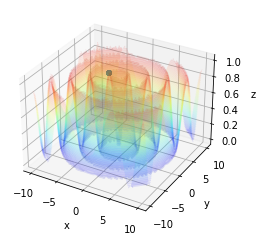

In [12]:
def schaffer_function_plot(x,y):
    g = 0.5 + (np.power((np.sin( np.sqrt( np.power(x, 2) + np.power(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (np.power(x, 2) + np.power(y, 2)))
    return g

value_ranges = np.array([[-10,10], [-10,10]])
min_mat = value_ranges.T[0, :]
max_mat = value_ranges.T[1,:]
best_solutions_denorm = best_solutions * (max_mat - min_mat) + min_mat


x_data = best_solutions_denorm[:, 0]
y_data = best_solutions_denorm[:, 1]
z_data = schaffer_function_plot(x_data, y_data)
x = np.linspace(-10, 10, 50)
y = np.linspace(-10, 10, 50)

X, Y = np.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.1)
ax.scatter3D(x_data, y_data, z_data, alpha=1)
#ax.set_xlim3d(-10,10)
#ax.set_ylim3d(-10,10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


MovieWriter imagemagick unavailable; using Pillow instead.


Global optimal at f([-0.30303030303030276, -3.1313131313131315])=0.004918708674121586


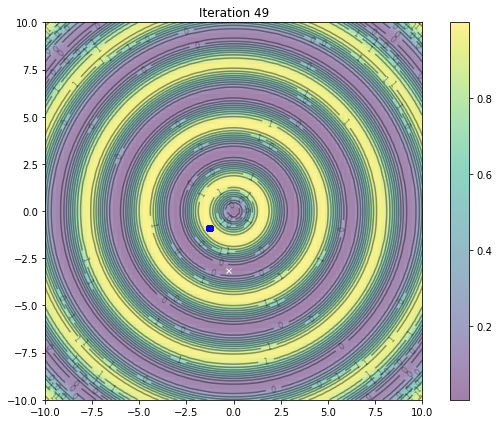

In [13]:
# Compute and plot the function in 3D within [0,5]x[0,5]
x, y = np.array(np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100)))
z = schaffer_function_plot(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]

particles = cmaes.x_i_history

fig, ax = plt.subplots(figsize=(8,6))
fig.set_tight_layout(True)
img = ax.imshow(z, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis', alpha=0.5)
fig.colorbar(img, ax=ax)
ax.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = ax.contour(x, y, z, 10, colors='black', alpha=0.4)
ax.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
#p_plot = ax.scatter(X[0], X[1], marker='o', color='blue', alpha=0.5)
#pbest_plot = ax.scatter(pbests[0][:,0],pbests[0][:,1], marker='o', color='black', alpha=0.5)
p_plot = ax.scatter(particles[0][:,0], particles[0][:,1], marker='o', color='blue', alpha=0.5)
#p_arrow = ax.quiver(particles[0][:,0], particles[0][:,1], speeds[0][:,0], speeds[1][:,1], color='blue', width=0.005, angles='xy', scale_units='xy', scale=1)
#gbest_plot = plt.scatter([gbests[0][0]], [gbests[0][1]], marker='*', s=100, color='black', alpha=0.4)

ax.set_xlim([-10,10])
ax.set_ylim([-10,10])


def animate(i):
    "Steps of PSO: algorithm update and show in plot"
    title = 'Iteration {:02d}'.format(i)
    ax.set_title(title)
    #pbest_plot.set_offsets(pbests[i])
    p_plot.set_offsets(particles[i])
    #p_arrow.set_offsets(particles[i])
    #p_arrow.set_UVC(speeds[i][:,0], speeds[i][:,1])
    #gbest_plot.set_offsets(gbests[i].reshape(1,-1))
    return ax, p_plot

anim = FuncAnimation(fig, animate, frames=list(range(1,len(particles))), interval=150, blit=False, repeat=True)
anim.save("cmaes.gif", dpi=120, writer="imagemagick")

#print("PSO found best solution at f({})={}".format(gbest, gbest_obj))
print("Global optimal at f({})={}".format([x_min,y_min], schaffer_function_plot(x_min,y_min)))
#HTML(anim.to_jshtml())
